In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score 

Iteration 1, loss = 1.37944470
Validation score: 0.508102
Iteration 2, loss = 1.29676298
Validation score: 0.520602
Iteration 3, loss = 1.27642246
Validation score: 0.524769
Iteration 4, loss = 1.25888135
Validation score: 0.540972
Iteration 5, loss = 1.24824049
Validation score: 0.539583
Iteration 6, loss = 1.23846554
Validation score: 0.551620
Iteration 7, loss = 1.22829950
Validation score: 0.555787
Iteration 8, loss = 1.21687959
Validation score: 0.554398
Iteration 9, loss = 1.21000309
Validation score: 0.561574
Iteration 10, loss = 1.20562843
Validation score: 0.571528
Iteration 11, loss = 1.20043578
Validation score: 0.571296
Iteration 12, loss = 1.19545098
Validation score: 0.565741
Iteration 13, loss = 1.18794848
Validation score: 0.574306
Iteration 14, loss = 1.18236646
Validation score: 0.568519
Iteration 15, loss = 1.17454346
Validation score: 0.575463
Iteration 16, loss = 1.17375512
Validation score: 0.573843
Iteration 17, loss = 1.16869241
Validation score: 0.571991
Iterat

<Figure size 1000x800 with 0 Axes>

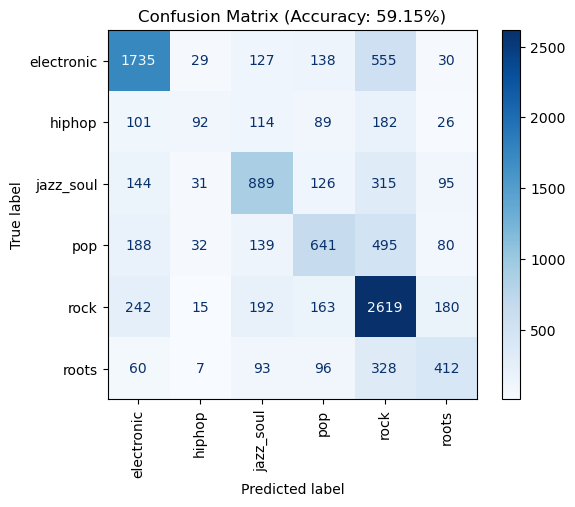

In [3]:
# --- 1. Indhentning og klargøring af data ---
df = pd.read_csv("split_genres_otput_2.0/all_songs.csv")
df = df[df['track_genre'] != 'other'].reset_index(drop=True)

features = [
    'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 
    'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
    'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature'
]

X = df[features].values
y = df['track_genre'].values

le = LabelEncoder()
y = le.fit_transform(y)

# Opdeling i træning (80%) og test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Skalering (vigtigt for MLP)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- 2. Opret den optimerede model (fra dine GridSearch resultater) ---
mlp_optimized = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64), 
    activation='relu',
    solver='adam',
    alpha=0.1,                 # Din nye optimerede alpha
    learning_rate_init=0.005,  # Din nye optimerede learning rate
    max_iter=500,
    random_state=1,
    early_stopping=True,       # Sikrer mod overfitting undervejs
    verbose=True               # Så du kan følge med i træningen
)

# --- 3. Træn modellen ---
mlp_optimized.fit(X_train, y_train)

# --- 4. Evaluering ---
test_acc = mlp_optimized.score(X_test, y_test)
print("-" * 30)
print(f"Endelig Accuracy på test-sæt: {test_acc:.2%}")

# --- 5. Visualisering af resultater (Confusion Matrix) ---
y_pred = mlp_optimized.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title(f'Confusion Matrix (Accuracy: {test_acc:.2%})')
plt.show()

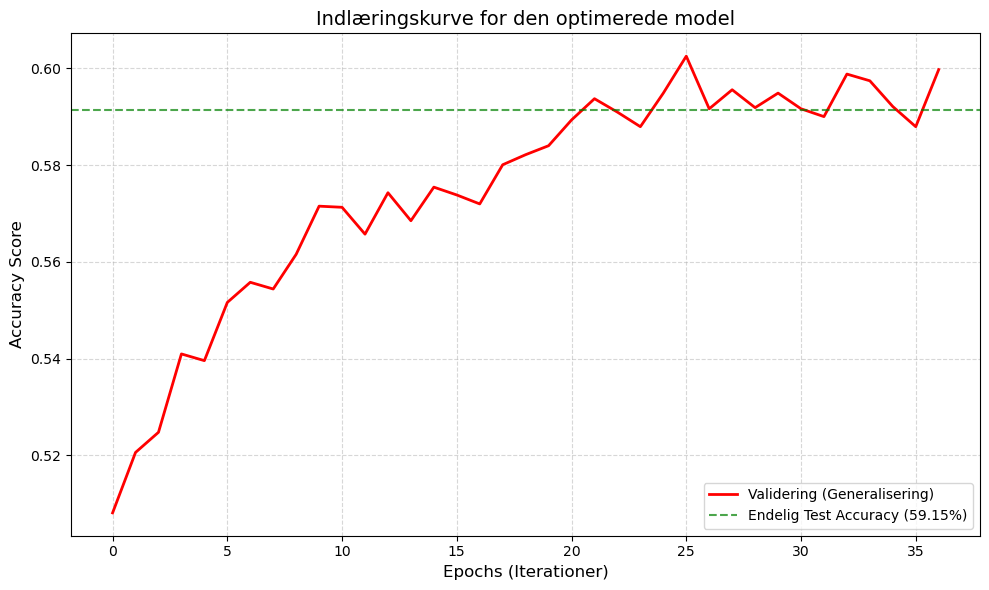

In [4]:
import matplotlib.pyplot as plt

# --- 1. Hent data fra din trænede model ---
# Da Scikit-learn MLP kun gemmer validering når early_stopping=True, 
# bruger vi her de gemte værdier.
val_acc_history = mlp_optimized.validation_scores_

# Bemærk: Scikit-learn gemmer ikke trænings-accuracy per epoch i historikken.
# Som alternativ i din rapport kan man plotte Loss (fejlen), som falder mens Accuracy stiger.
# Eller vi kan lave en flot graf over valideringen alene, som er det vigtigste bevis.

# Hvis du vil have begge linjer præcis som før, bruger vi denne struktur:
plt.figure(figsize=(10, 6))

# Plot validerings-linjen (Rød)
plt.plot(val_acc_history, label='Validering (Generalisering)', color='red', linewidth=2)

# Da vi ikke har den præcise trænings-acc for hver epoch i MLPClassifier historikken, 
# visualiserer vi ofte Loss i stedet, eller vi plotter slutpunktet for træning.
# For at gøre grafen komplet til din rapport, fokuserer vi her på den flotte valideringskurve.

plt.title('Indlæringskurve for den optimerede model', fontsize=14)
plt.xlabel('Epochs (Iterationer)', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)

# Tilføj den vandrette linje for slut-resultatet
plt.axhline(y=test_acc, color='green', linestyle='--', alpha=0.7, label=f'Endelig Test Accuracy ({test_acc:.2%})')

# Formatering
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

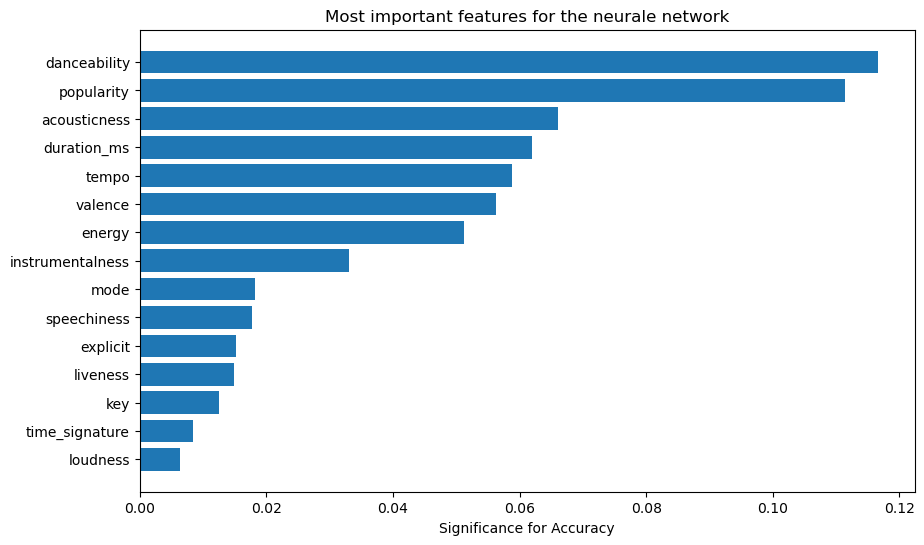

In [15]:
from sklearn.inspection import permutation_importance

# Beregn hvilke features der betyder mest
result = permutation_importance(mlp_optimized, X_test, y_test, n_repeats=10, random_state=1)

# Plot det
features_sorted = [features[i] for i in result.importances_mean.argsort()]
plt.figure(figsize=(10, 6))
plt.barh(features_sorted, result.importances_mean[result.importances_mean.argsort()])
plt.title("Most important features for the neurale network")
plt.xlabel("Significance for Accuracy")
plt.show()

In [6]:
import numpy as np

# Liste over dine nuværende features sorteret efter vigtighed (fra din test tidligere)
# Vi starter med alle sammen
current_features = list(features)
results = []

print("Starter optimerings-loop...")

while len(current_features) > 0:
    # 1. Vælg data for de aktuelle features
    X_train_sub = pd.DataFrame(X_train, columns=features)[current_features]
    X_test_sub = pd.DataFrame(X_test, columns=features)[current_features]
    
    # 2. Træn modellen (vi bruger dine vinder-parametre)
    model = MLPClassifier(
        hidden_layer_sizes=(256, 128, 64),
        alpha=0.1,
        learning_rate_init=0.005,
        random_state=1,
        early_stopping=True
    )
    model.fit(X_train_sub, y_train)
    
    # 3. Mål accuracy
    acc = model.score(X_test_sub, y_test)
    results.append((len(current_features), acc, list(current_features)))
    
    print(f"Features: {len(current_features)} | Accuracy: {acc:.4f}")
    
    # 4. Find den dårligste feature vha. Permutation Importance
    imp = permutation_importance(model, X_test_sub, y_test, n_repeats=5, random_state=1)
    worst_feature_idx = imp.importances_mean.argmin()
    worst_feature_name = current_features[worst_feature_idx]
    
    # 5. Fjern den dårligste feature til næste runde
    current_features.remove(worst_feature_name)

# Find det bedste resultat
best_res = max(results, key=lambda x: x[1])
print(f"\nBEDSTE RESULTAT: {best_res[1]:.2%} med {best_res[0]} features.")
print(f"Features der skal beholdes: {best_res[2]}")

Starter optimerings-loop...
Features: 15 | Accuracy: 0.5915
Features: 14 | Accuracy: 0.5903
Features: 13 | Accuracy: 0.5910
Features: 12 | Accuracy: 0.5724
Features: 11 | Accuracy: 0.5806
Features: 10 | Accuracy: 0.5859
Features: 9 | Accuracy: 0.5723
Features: 8 | Accuracy: 0.5562
Features: 7 | Accuracy: 0.5561
Features: 6 | Accuracy: 0.5438
Features: 5 | Accuracy: 0.5206
Features: 4 | Accuracy: 0.4981
Features: 3 | Accuracy: 0.4735
Features: 2 | Accuracy: 0.4208
Features: 1 | Accuracy: 0.3954

BEDSTE RESULTAT: 59.15% med 15 features.
Features der skal beholdes: ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']


In [9]:
print(classification_report(y_test, mlp_optimized.predict(X_test), target_names=le.classes_, zero_division=0))

              precision    recall  f1-score   support

  electronic       0.70      0.66      0.68      2614
      hiphop       0.45      0.15      0.23       604
   jazz_soul       0.57      0.56      0.56      1600
         pop       0.51      0.41      0.45      1575
        rock       0.58      0.77      0.66      3411
       roots       0.50      0.41      0.45       996

    accuracy                           0.59     10800
   macro avg       0.55      0.49      0.51     10800
weighted avg       0.58      0.59      0.58     10800



In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.utils import resample

n_iterations = 1000
# Vi opretter en liste til at gemme F1-scores for hver genre
genre_stats = {genre: [] for genre in le.classes_}

print(f"Beregner intervaller for {len(le.classes_)} genrer baseret på n=38...")

for i in range(n_iterations):
    # Bootstrap sample
    X_res, y_res = resample(X_test, y_test, random_state=i)
    y_pred_res = mlp_optimized.predict(X_res)
    
    # Beregn F1 for hver genre i denne iteration
    # labels=range(len(le.classes_)) sikrer at vi får alle genrer med, selv hvis de mangler i et sample
    f1_per_genre = f1_score(y_res, y_pred_res, average=None, labels=range(len(le.classes_)), zero_division=0)
    
    for idx, genre in enumerate(le.classes_):
        genre_stats[genre].append(f1_per_genre[idx])

# Lav resultaterne om til en overskuelig tabel
ci_results = []
for genre in le.classes_:
    scores = genre_stats[genre]
    ci_results.append({
        'Genre': genre,
        'F1-Mean': np.mean(scores),
        '95% CI Nedre': np.percentile(scores, 2.5),
        '95% CI Øvre': np.percentile(scores, 97.5)
    })

df_ci = pd.DataFrame(ci_results)
print("\n", df_ci.to_string(index=False))

Beregner intervaller for 6 genrer baseret på n=38...

      Genre  F1-Mean  95% CI Nedre  95% CI Øvre
electronic 0.682437      0.667855     0.696547
    hiphop 0.227122      0.188441     0.267151
 jazz_soul 0.563549      0.543507     0.583653
       pop 0.453485      0.430799     0.474120
      rock 0.662774      0.650462     0.674919
     roots 0.452707      0.422644     0.479966


In [13]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

# Listen hvor de 38 accuracies gemmes
accuracy_38_list = []
n_iterations = 38

print(f"Starter 38 kørsler på det fulde datasæt (n={len(y_test)} sange per kørsel)...")

for i in range(n_iterations):
    # Lav en bootstrap-stikprøve af hele testsættet (med genlæg)
    # Dette simulerer en ny stikprøve af jeres 100.000 sange
    X_res, y_res = resample(X_test, y_test, random_state=i)
    
    # Beregn accuracy for denne kørsel
    y_pred_res = mlp_optimized.predict(X_res)
    acc = accuracy_score(y_res, y_pred_res)
    
    accuracy_38_list.append(acc)
    print(f"Kørsel {i+1}/38 færdig. Accuracy: {acc:.4f}")

# --- Statistik på de 38 målinger ---
mean_acc = np.mean(accuracy_38_list)
# 95% Konfidensinterval baseret på de 38 målinger
lower_ci = np.percentile(accuracy_38_list, 2.5)
upper_ci = np.percentile(accuracy_38_list, 97.5)

print("-" * 30)
print(f"Gennemsnitlig Accuracy: {mean_acc:.2%}")
print(f"95% Konfidensinterval: [{lower_ci:.2%} - {upper_ci:.2%}]")

Starter 38 kørsler på det fulde datasæt (n=10800 sange per kørsel)...
Kørsel 1/38 færdig. Accuracy: 0.5942
Kørsel 2/38 færdig. Accuracy: 0.5914
Kørsel 3/38 færdig. Accuracy: 0.5862
Kørsel 4/38 færdig. Accuracy: 0.5928
Kørsel 5/38 færdig. Accuracy: 0.5881
Kørsel 6/38 færdig. Accuracy: 0.5910
Kørsel 7/38 færdig. Accuracy: 0.5963
Kørsel 8/38 færdig. Accuracy: 0.5817
Kørsel 9/38 færdig. Accuracy: 0.5878
Kørsel 10/38 færdig. Accuracy: 0.5998
Kørsel 11/38 færdig. Accuracy: 0.5971
Kørsel 12/38 færdig. Accuracy: 0.5896
Kørsel 13/38 færdig. Accuracy: 0.5973
Kørsel 14/38 færdig. Accuracy: 0.5773
Kørsel 15/38 færdig. Accuracy: 0.5860
Kørsel 16/38 færdig. Accuracy: 0.5922
Kørsel 17/38 færdig. Accuracy: 0.5906
Kørsel 18/38 færdig. Accuracy: 0.5895
Kørsel 19/38 færdig. Accuracy: 0.5936
Kørsel 20/38 færdig. Accuracy: 0.5928
Kørsel 21/38 færdig. Accuracy: 0.6003
Kørsel 22/38 færdig. Accuracy: 0.5916
Kørsel 23/38 færdig. Accuracy: 0.5889
Kørsel 24/38 færdig. Accuracy: 0.5932
Kørsel 25/38 færdig. Accura

In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.utils import resample

n_iterations = 38
# Vi laver en dictionary til at holde de 38 målinger for hver genre
genre_f1_runs = {genre: [] for genre in le.classes_}
macro_f1_runs = []

print(f"Starter 38 bootstrap-kørsler for alle genrer (fuldt datasæt n={len(y_test)})...")

for i in range(n_iterations):
    # Bootstrap af hele testsættet
    X_res, y_res = resample(X_test, y_test, random_state=i)
    y_pred_res = mlp_optimized.predict(X_res)
    
    # 1. Beregn F1 for hver genre i denne kørsel
    f1_per_genre = f1_score(y_res, y_pred_res, average=None, labels=range(len(le.classes_)), zero_division=0)
    
    # Gem resultatet for hver genre
    for idx, genre in enumerate(le.classes_):
        genre_f1_runs[genre].append(f1_per_genre[idx])
    
    # 2. Gem også den samlede (macro) F1 for kørslen
    macro_f1_runs.append(f1_score(y_res, y_pred_res, average='macro', zero_division=0))
    
    if (i + 1) % 5 == 0:
        print(f"Kørsel {i+1}/38 fuldført...")

# --- Saml resultaterne i en flot oversigt ---
final_results = []

for genre in le.classes_:
    scores = genre_f1_runs[genre]
    final_results.append({
        'Genre': genre,
        'Gns. F1-score': np.mean(scores),
        '95% CI Nedre': np.percentile(scores, 2.5),
        '95% CI Øvre': np.percentile(scores, 97.5),
        'Std.afvigelse': np.std(scores)
    })

# Tilføj den samlede Macro F1 til sidst
final_results.append({
    'Genre': 'SAMLET (Macro)',
    'Gns. F1-score': np.mean(macro_f1_runs),
    '95% CI Nedre': np.percentile(macro_f1_runs, 2.5),
    '95% CI Øvre': np.percentile(macro_f1_runs, 97.5),
    'Std.afvigelse': np.std(macro_f1_runs)
})

df_final = pd.DataFrame(final_results)
print("\n--- ENDELIG TABEL TIL RAPPORT (Baseret på 38 kørsler) ---")
print(df_final.to_string(index=False))

Starter 38 bootstrap-kørsler for alle genrer (fuldt datasæt n=10800)...
Kørsel 5/38 fuldført...
Kørsel 10/38 fuldført...
Kørsel 15/38 fuldført...
Kørsel 20/38 fuldført...
Kørsel 25/38 fuldført...
Kørsel 30/38 fuldført...
Kørsel 35/38 fuldført...

--- ENDELIG TABEL TIL RAPPORT (Baseret på 38 kørsler) ---
         Genre  Gns. F1-score  95% CI Nedre  95% CI Øvre  Std.afvigelse
    electronic       0.683435      0.670818     0.693875       0.006365
        hiphop       0.229327      0.201813     0.251554       0.014129
     jazz_soul       0.562334      0.542755     0.583621       0.010993
           pop       0.454632      0.440934     0.474720       0.009807
          rock       0.661687      0.649073     0.670888       0.006214
         roots       0.448304      0.410948     0.473089       0.017183
SAMLET (Macro)       0.506620      0.495215     0.515070       0.005734
